[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference
- Upload dataset and model to Roboflow (coming soon)

## 🔥 Let's begin!


## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jun 11 09:28:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [2]:
!pip install -q \
  autodistill \
  autodistill-grounded-sam \
  autodistill-yolov8 \
  roboflow \
  supervision==0.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [4]:
!mkdir {HOME}/images

## Download Images

Below, we provide two methods of retrieving images for use with Autodistill:

1. Download a dataset with images from Roboflow, and;
2. Download a raw video and split it up into images.

For this guide, we will be using a raw video to train our model.

### Download Images from Roboflow

You can download datasets from Roboflow using the below lines of code. You can download datasets associated with your account, or any of the 200,000+ public datasets on [Roboflow Universe](https://universe.roboflow.com/). To download a dataset from Roboflow, you will need a [free Roboflow account](https://app.roboflow.com).

You need to paste in a URL to a full model, like so:

```
https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16
```

To find a model URL, go to a dataset page on Universe (i.e. the [TACO dataset](https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/)), then click "Model" in the sidebar to view the latest model version. Copy the page URL, then paste it into the `download_dataset()` function below.

![Universe model link](https://media.roboflow.com/universe_deploy_tab.png)

Uncomment the lines of code below to use the Roboflow dataset upload.

In [ ]:
# import roboflow

# roboflow.login()

# dataset = roboflow.download_dataset(dataset_url="https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16", model_format="yolov8")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TACO:-Trash-Annotations-in-Context-Dataset-16 in yolov8:: 100%|██████████| 7204/7204 [00:01<00:00, 5532.14it/s]


Once you have downloaded your dataset, move all of the images from the `train` set in your downloaded dataset into the `images/` directory we created earlier:

In [ ]:
%mv {dataset.location}/train/* {HOME}/images

Now we are ready to start using Autodistill!

### Download raw videos

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

In [6]:
!mkdir {HOME}/videos
%cd {HOME}/videos

# # download zip file containing videos
# !wget https://media.roboflow.com/milk.zip

# # unzip videos
# !unzip milk.zip

mkdir: cannot create directory ‘/content/videos’: File exists
/content/videos


### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [7]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 500

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [12]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4", "mkv"])

# TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]
TRAIN_VIDEO_PATHS = video_paths[0:2]
print(TRAIN_VIDEO_PATHS)

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

[PosixPath('/content/videos/STA_EIK_part3.mkv')]


  0%|          | 0/1 [00:00<?, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [13]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 77


**NOTE:** We can also plot sample of our image dataset.

In [14]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 10)

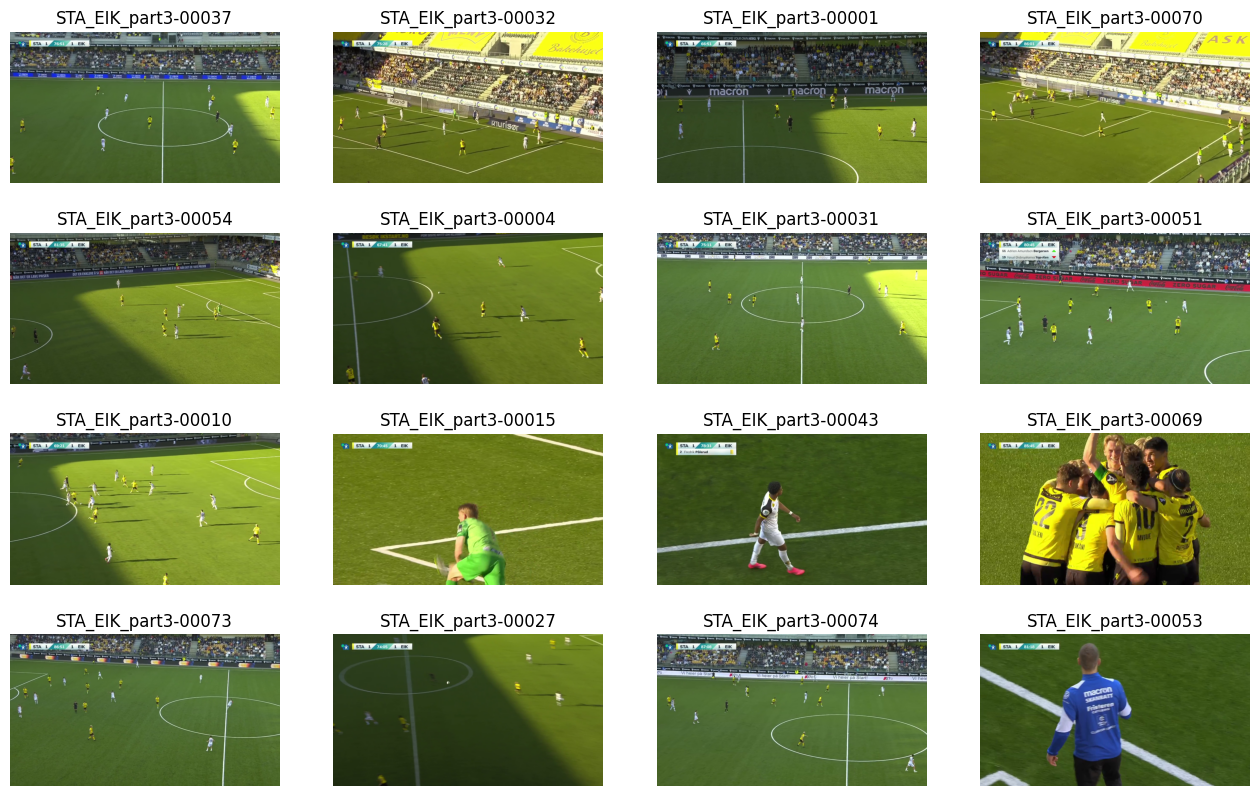

In [15]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [32]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "brand logo": "logo",
    "logo": "logo",
    "small brand logo": "logo",
    "small logo": "logo",
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [33]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [34]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/images/STA_EIK_part3-00037.png:   0%|          | 0/77 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Labeling /content/images/STA_EIK_part3-00011.png: 100%|██████████| 77/77 [05:31<00:00,  4.31s/it]


Found /content/dataset/train/images/STA_EIK_part3-00049.jpg as already present, not moving anything to /content/dataset/train/images
Found /content/dataset/train/labels/STA_EIK_part3-00049.txt as already present, not moving anything to /content/dataset/train/labels
Found /content/dataset/train/images/STA_EIK_part3-00064.jpg as already present, not moving anything to /content/dataset/train/images
Found /content/dataset/train/labels/STA_EIK_part3-00064.txt as already present, not moving anything to /content/dataset/train/labels
Found /content/dataset/train/images/STA_EIK_part3-00053.jpg as already present, not moving anything to /content/dataset/train/images
Found /content/dataset/train/labels/STA_EIK_part3-00053.txt as already present, not moving anything to /content/dataset/train/labels
Found /content/dataset/train/images/STA_EIK_part3-00019.jpg as already present, not moving anything to /content/dataset/train/images
Found /content/dataset/train/labels/STA_EIK_part3-00019.txt as alread

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [35]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [36]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

71

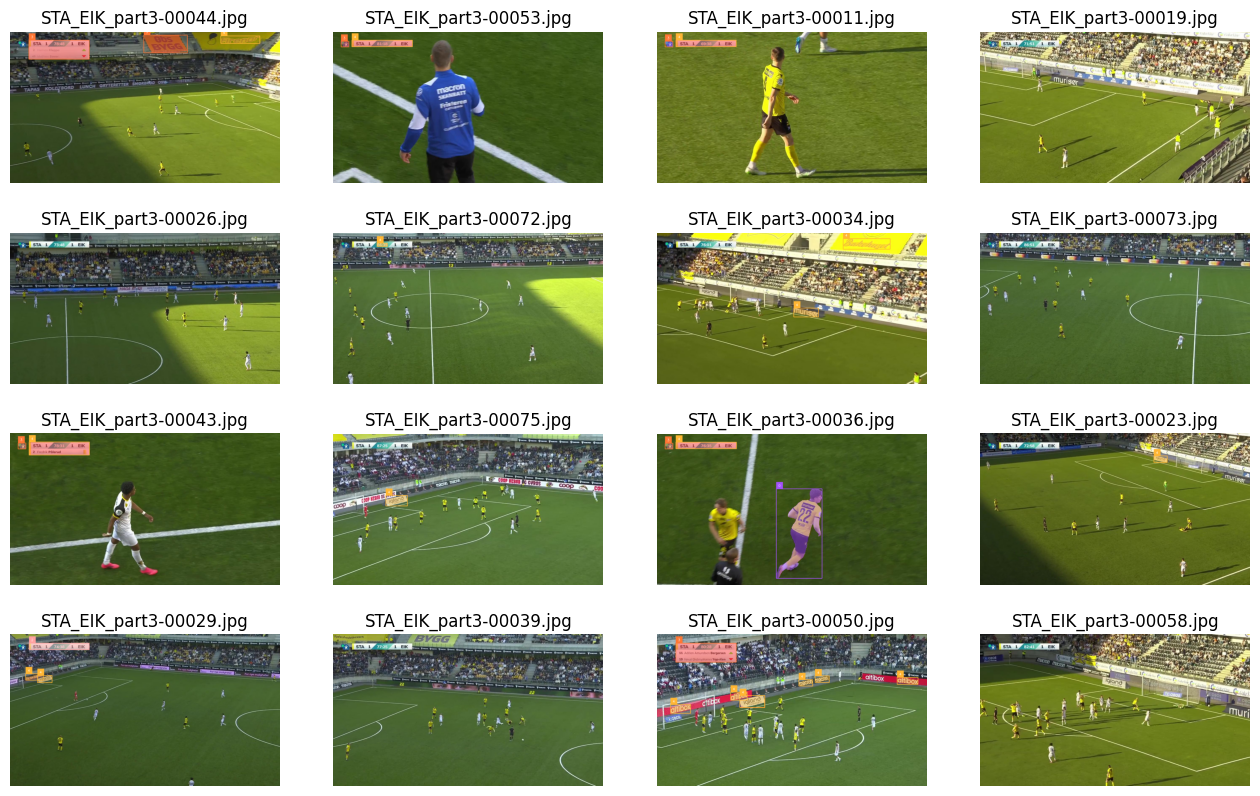

In [37]:
import supervision as sv
from pathlib import Path


mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

images = []
image_names = []
for i, (image_path, image, annotation) in enumerate(dataset):
    if i == SAMPLE_SIZE:
        break
    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = box_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=annotation)

    image_names.append(Path(image_path).name)
    images.append(annotated_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

STA_EIK_part3.mkv


In [38]:
from google.colab import files

!zip -r /content/dataset.zip /content/dataset

# Download the created zip file
files.download("/content/dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/dataset/ (stored 0%)
updating: content/dataset/train.zip (stored 0%)
updating: content/dataset/valid/ (stored 0%)
updating: content/dataset/valid/labels/ (stored 0%)
updating: content/dataset/valid/labels/STA_EIK_part3-00073.txt (deflated 86%)
updating: content/dataset/valid/labels/STA_EIK_part3-00061.txt (deflated 88%)
updating: content/dataset/valid/labels/STA_EIK_part3-00009.txt (deflated 70%)
updating: content/dataset/valid/labels/STA_EIK_part3-00020.txt (deflated 71%)
updating: content/dataset/valid/labels/STA_EIK_part3-00021.txt (deflated 92%)
updating: content/dataset/valid/labels/STA_EIK_part3-00059.txt (deflated 75%)
updating: content/dataset/valid/labels/STA_EIK_part3-00045.txt (deflated 75%)
updating: content/dataset/valid/labels/STA_EIK_part3-00069.txt (deflated 81%)
updating: content/dataset/valid/labels/STA_EIK_part3-00063.txt (deflated 72%)
updating: content/dataset/valid/labels/STA_EIK_part3-00041.txt (deflated 88%)
updating: content/dataset/valid/labe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

In [ ]:
# Fix intermittent Colab bug. You may not need this.
# NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png       train_batch1.jpg
confusion_matrix.png				    PR_curve.png      train_batch2.jpg
events.out.tfevents.1730458461.c20a45d5a855.5597.0  R_curve.png       val_batch0_labels.jpg
F1_curve.png					    results.csv       val_batch0_pred.jpg
labels_correlogram.jpg				    results.png       weights
labels.jpg					    train_batch0.jpg


## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/content


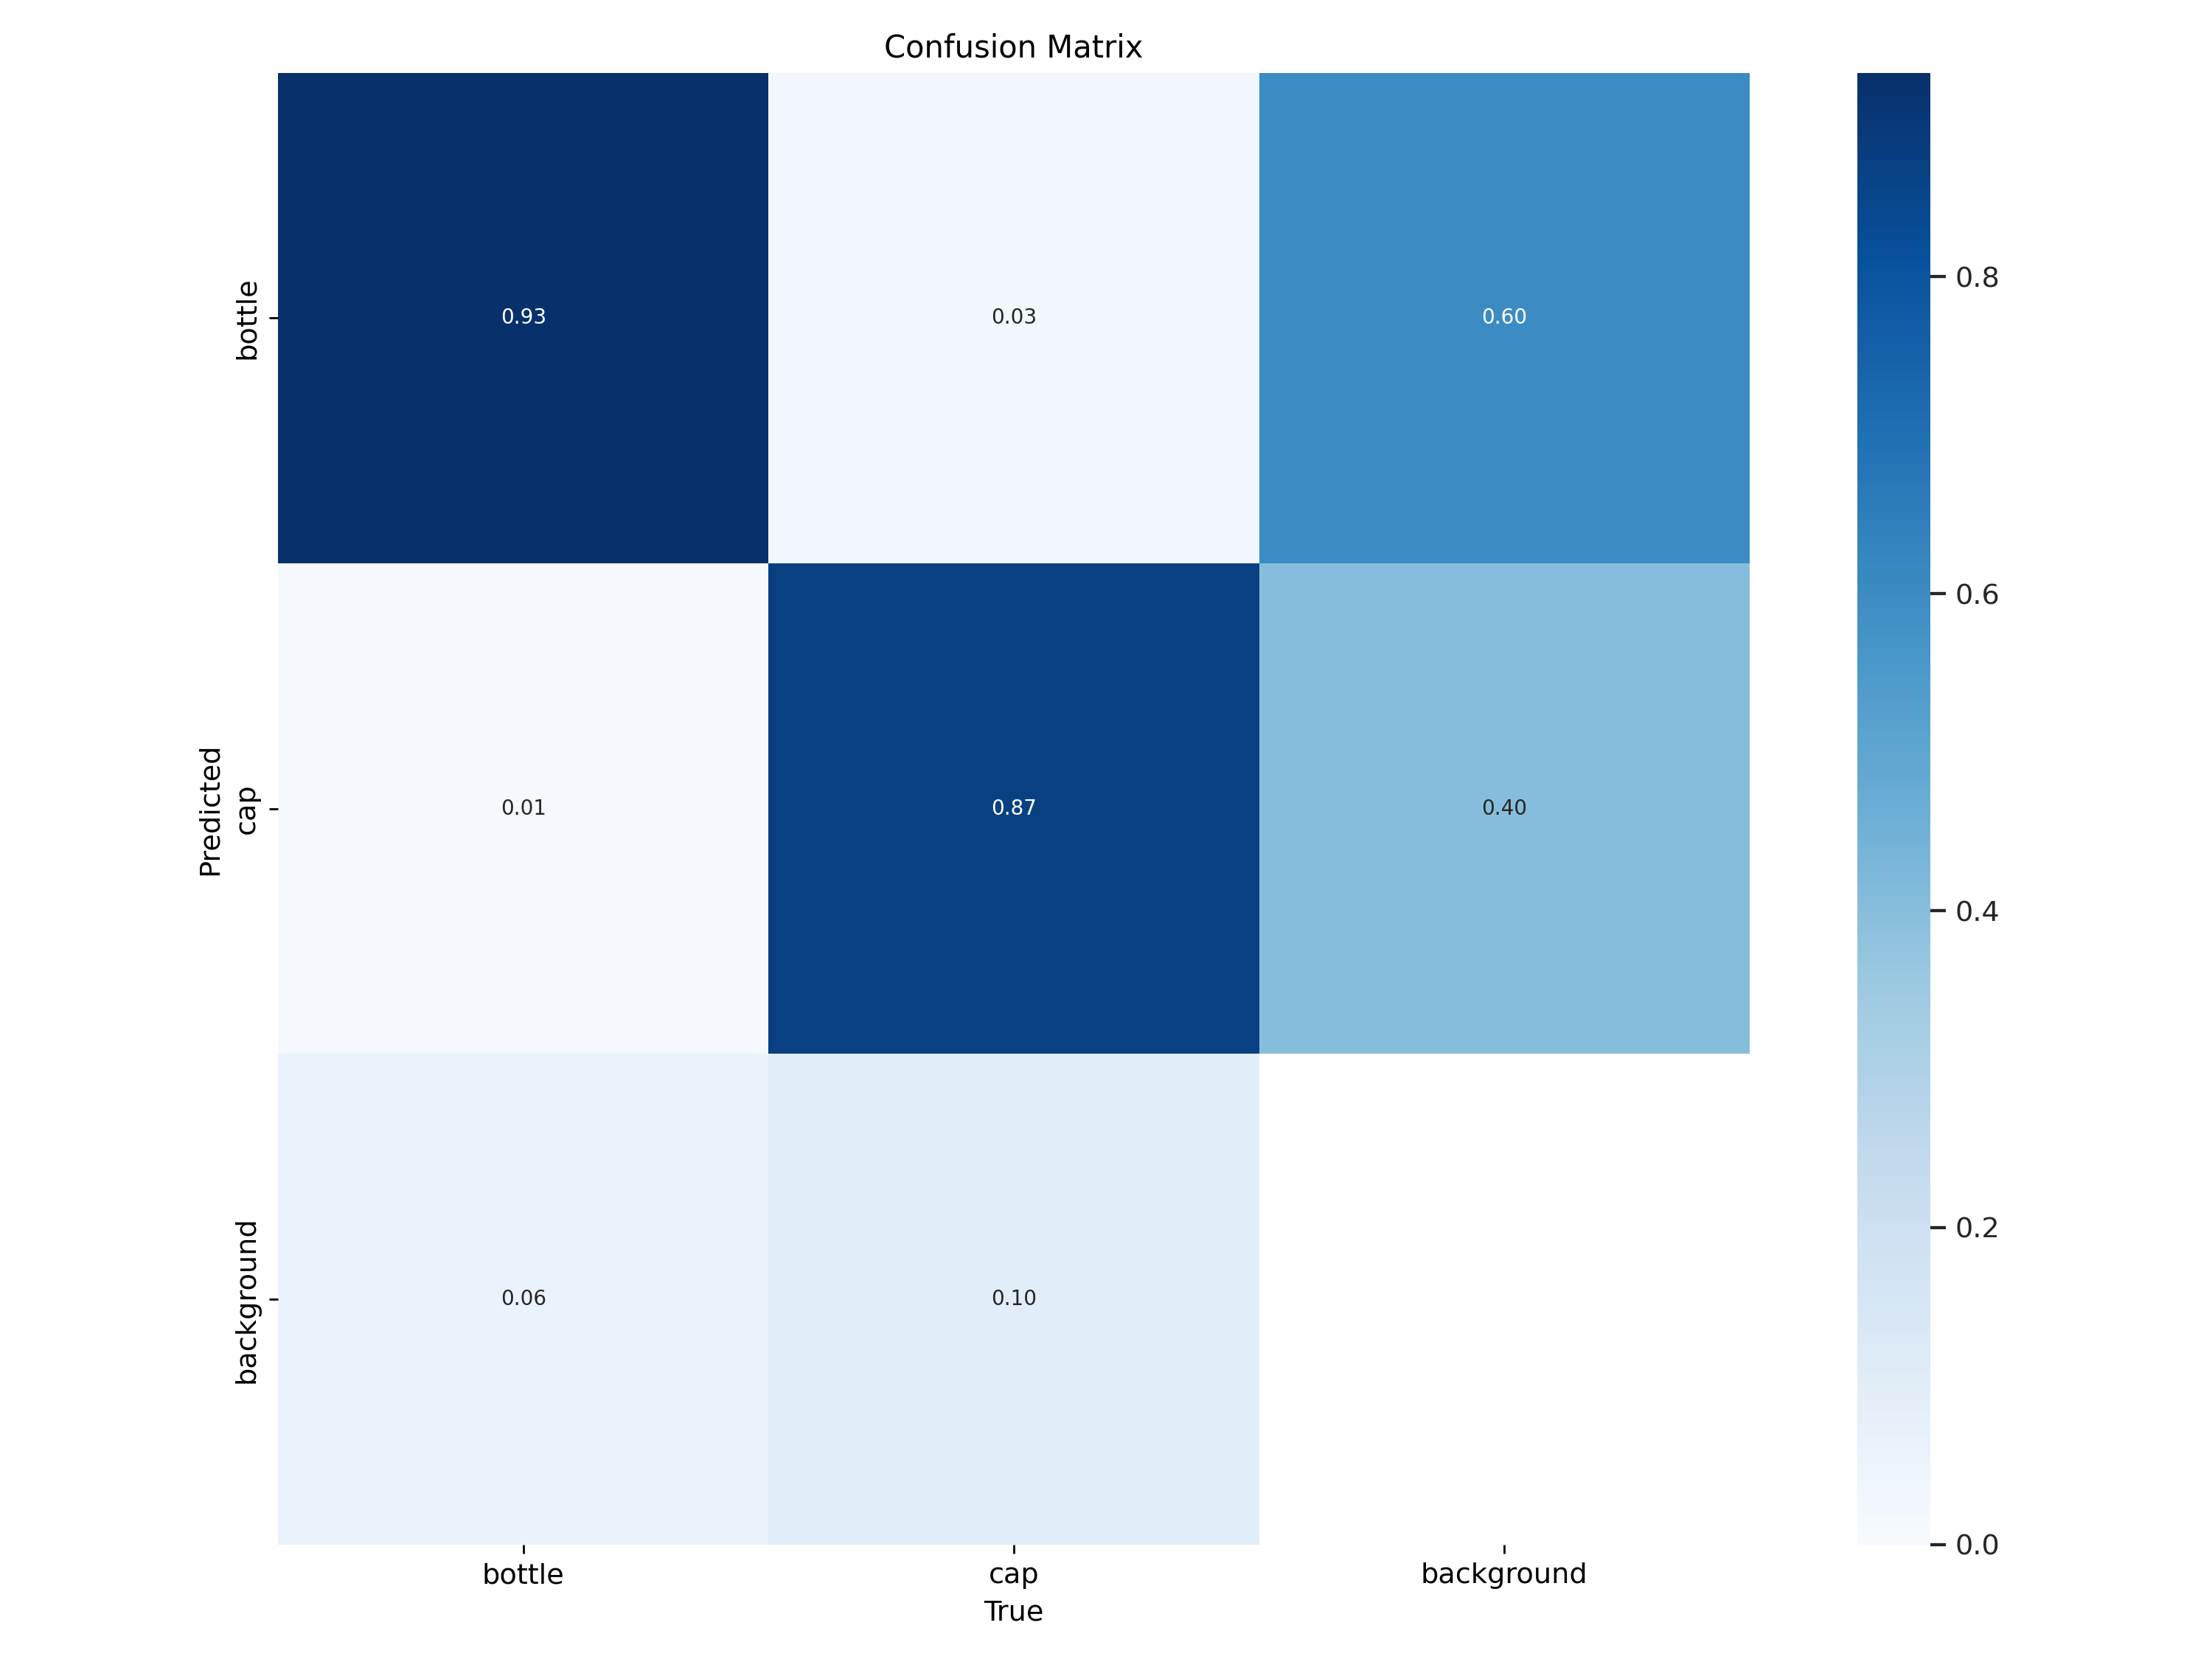

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


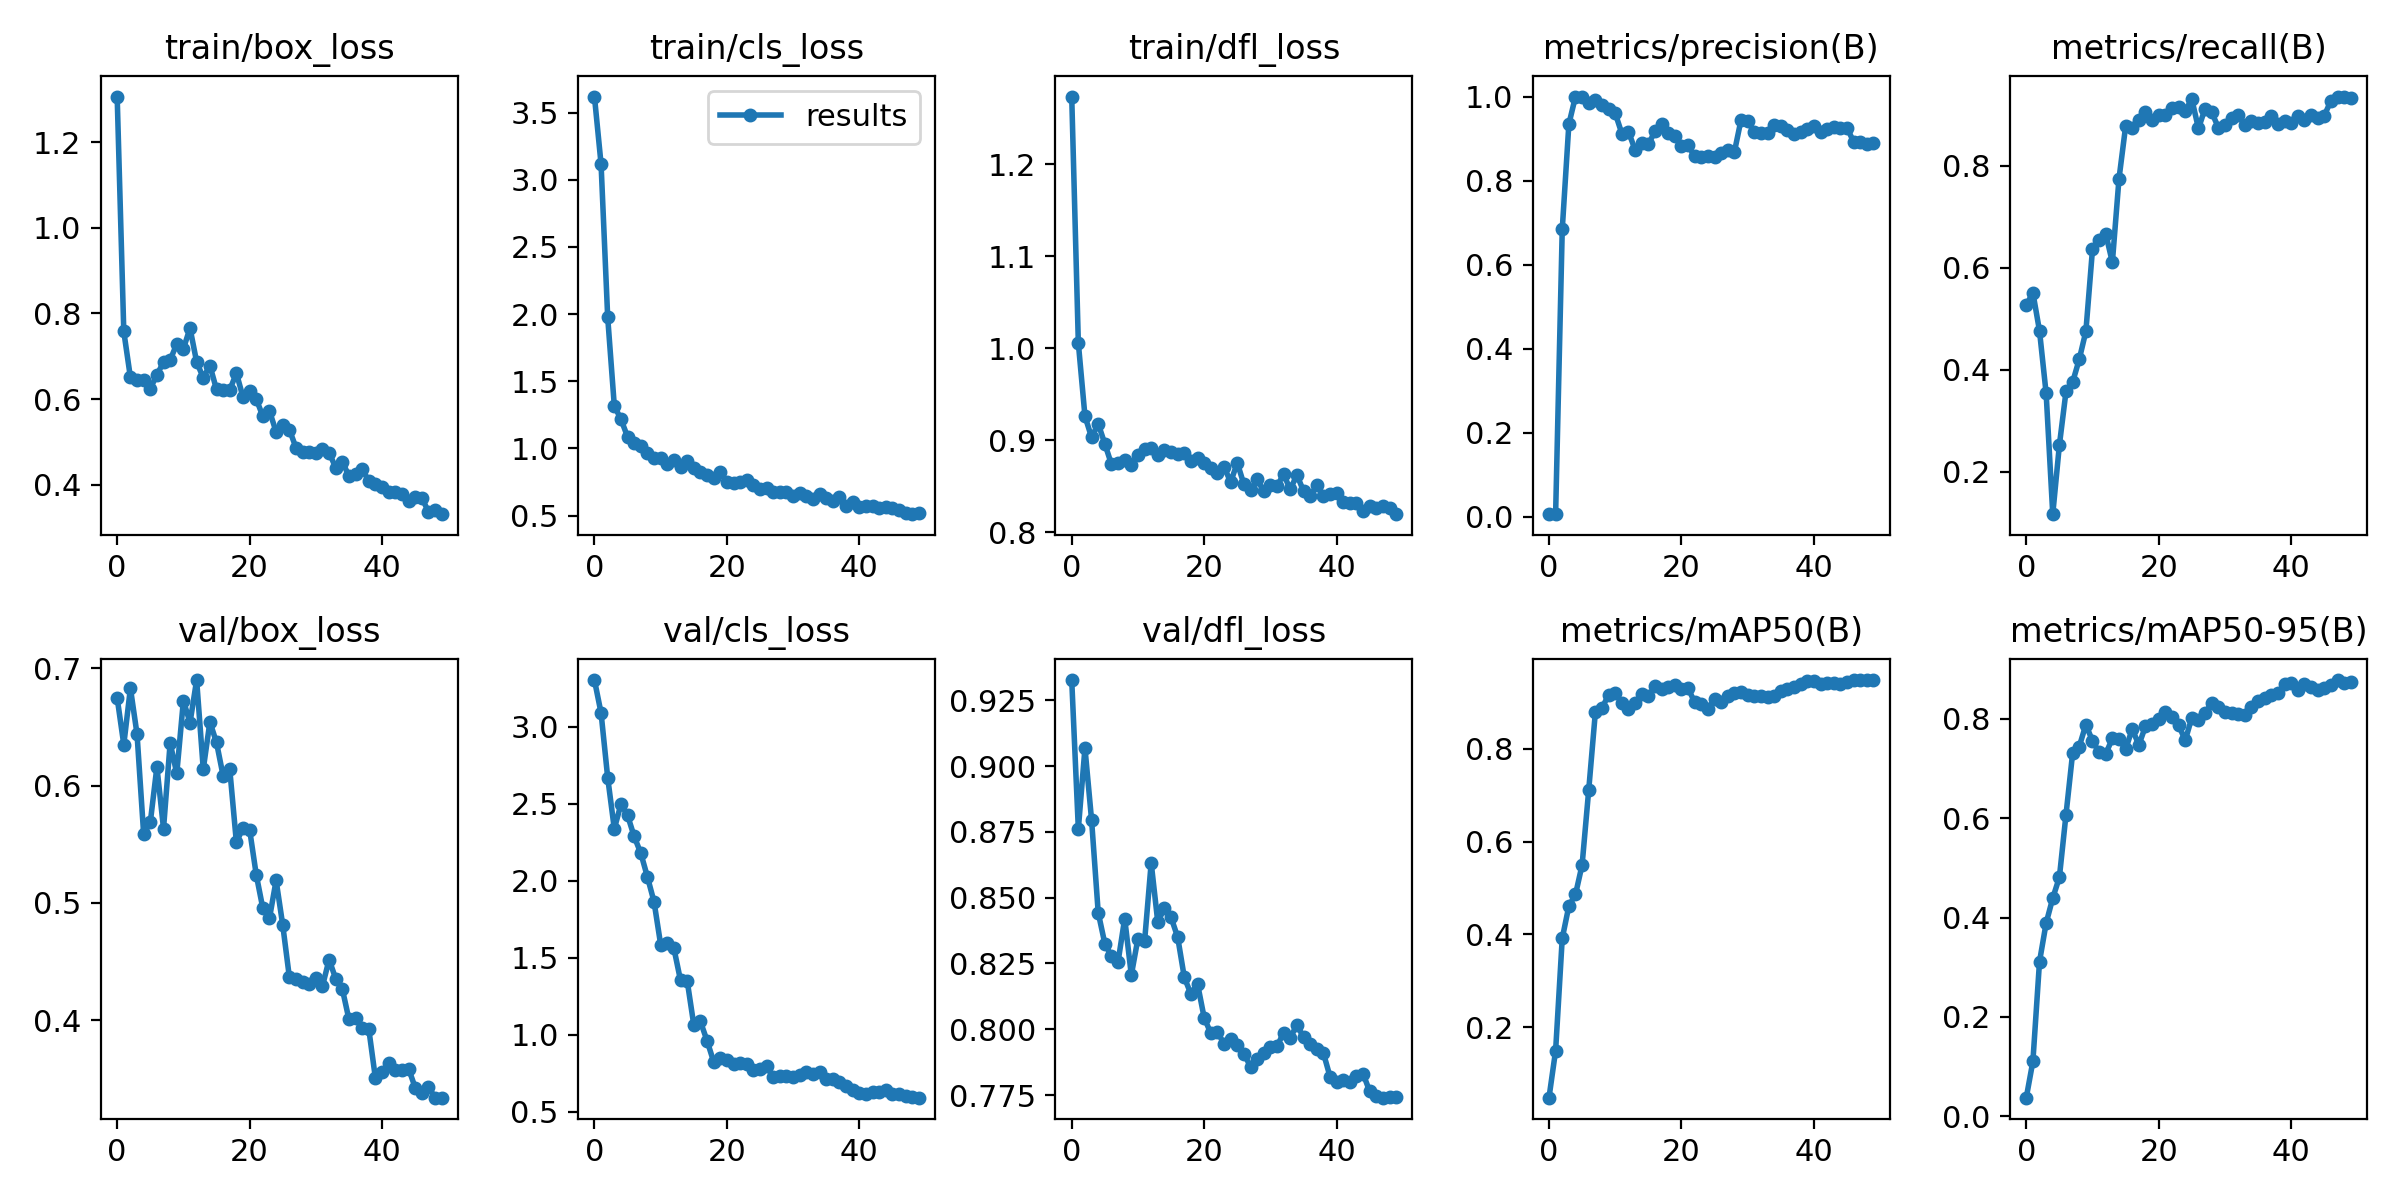

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


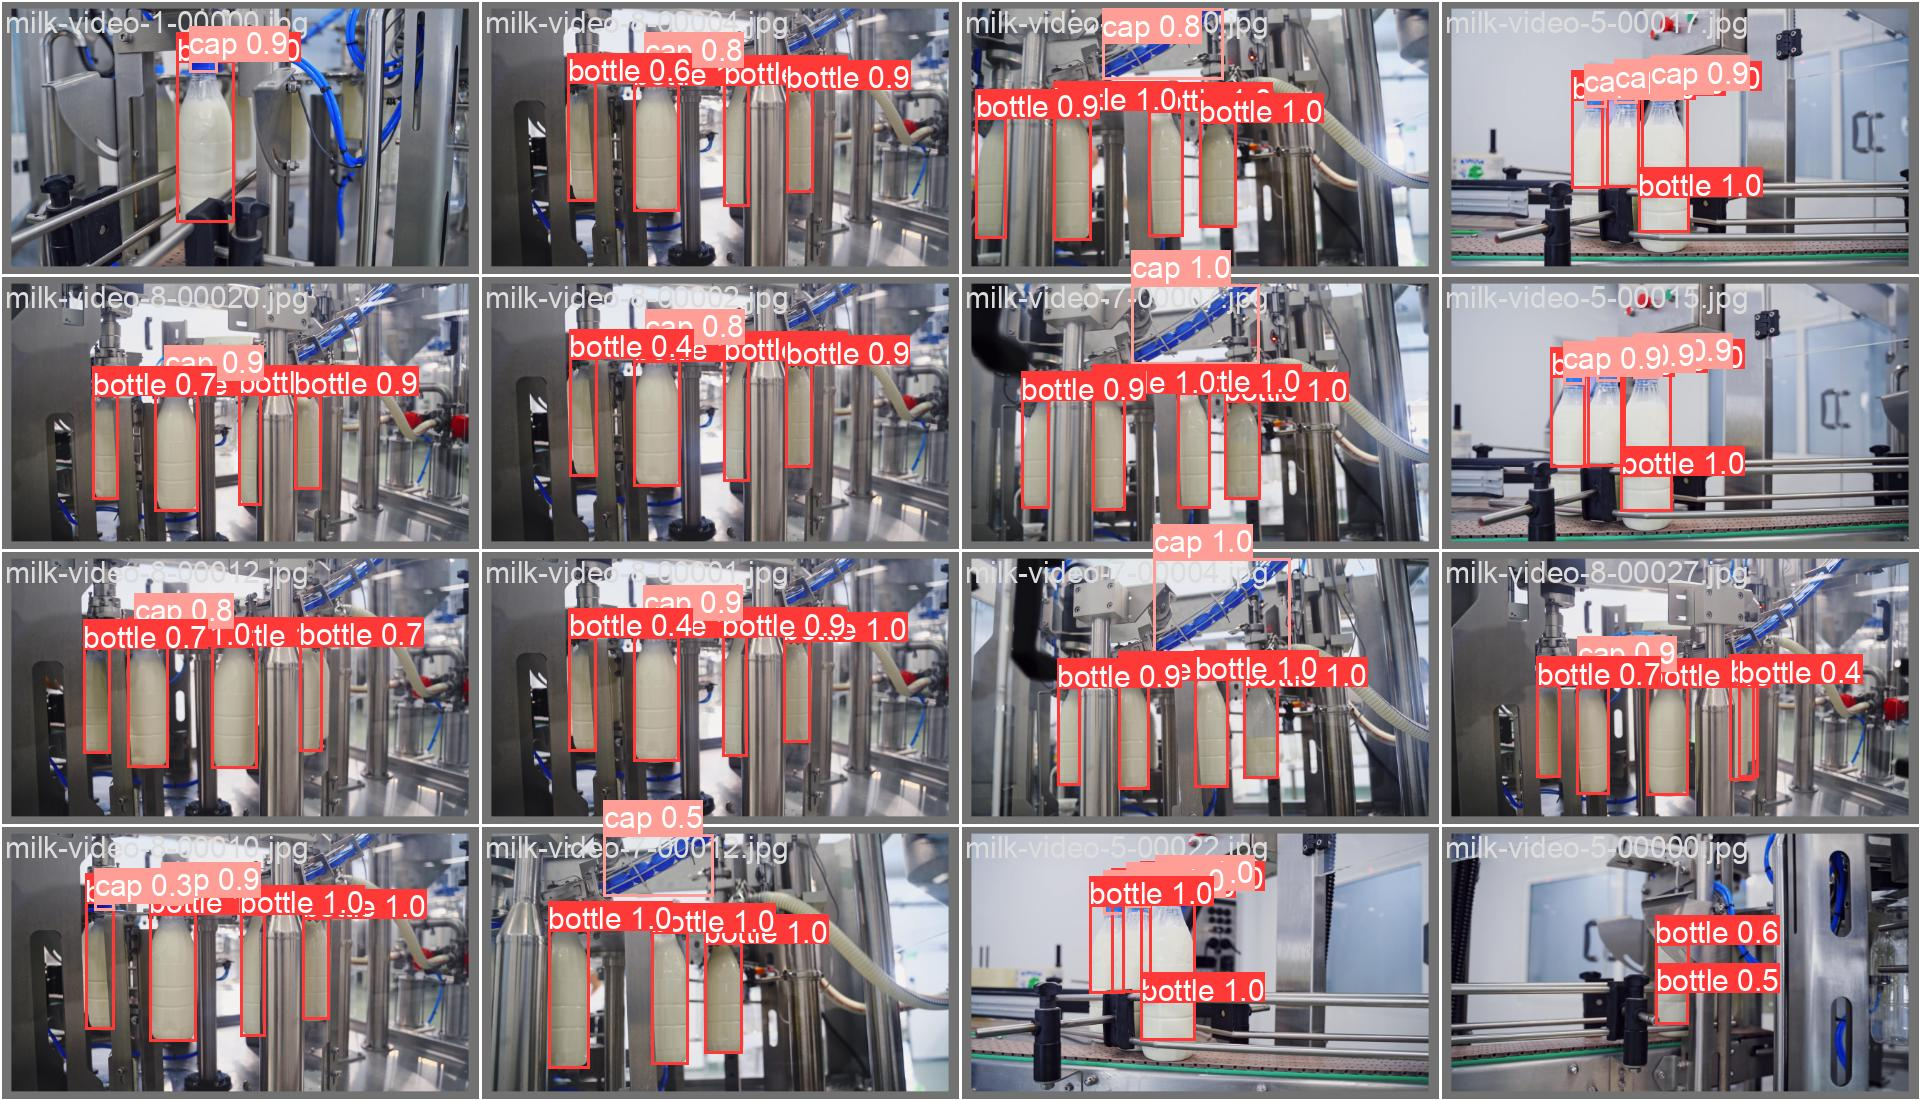

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [ ]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

In [ ]:
# Prediction saved as:
prediction_file = f"{HOME}/runs/detect/predict/milk-video-6.mp4"

## Upload dataset and model to Roboflow

coming soon...

  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.